# Predict steering angle with a simple ConvNet

In [1]:
import pandas as pd
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import train_util

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.models import load_model
from keras import metrics
import keras as K

Using TensorFlow backend.


# Loading Dataset

In [2]:
import pandas as pd
steering_labels = pd.read_csv("/home/ubuntu/dataset/udacity-driving/interpolated.csv")
print(steering_labels.shape)
steering_labels.head()

(45636, 12)


,index,timestamp,width,height,frame_id,filename,angle,torque,speed,lat,long,alt
0,2016-09-29 22:09:25.602401049,1475186965602401049,640,480,left_camera,left/1475186965602401049.jpg,-0.045649,-0.644359,14.605986,0.0,0.0,0.0
1,2016-09-29 22:09:25.609972775,1475186965609972775,640,480,center_camera,center/1475186965609972775.jpg,-0.046314,-0.691983,14.607044,0.0,0.0,0.0
2,2016-09-29 22:09:25.630938502,1475186965630938502,640,480,right_camera,right/1475186965630938502.jpg,-0.047124,-0.677232,14.611567,0.0,0.0,0.0
3,2016-09-29 22:09:25.652132892,1475186965652132892,640,480,left_camera,left/1475186965652132892.jpg,-0.047124,-0.585284,14.615654,0.0,0.0,0.0
4,2016-09-29 22:09:25.659735933,1475186965659735933,640,480,center_camera,center/1475186965659735933.jpg,-0.047099,-0.560746,14.616667,0.0,0.0,0.0


## Cropping images

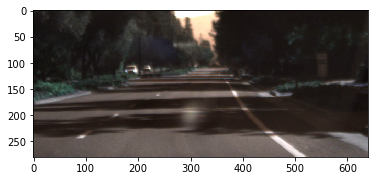

In [3]:
file_name = steering_labels.iloc[7]["filename"]
img_bgr = cv2.imread("/home/ubuntu/dataset/udacity-driving/" + file_name)
crop_img = img_bgr[200:480, 0:640] # Crop from x, y, w, h -> 100, 200, 300, 400
# NOTE: its img[y: y + h, x: x + w] 
plt.imshow(crop_img)
plt.show();

## Augmentation

In [10]:
# testing the generator
training_gen = generate_train_batch(steering_labels, 20)
batch_img, steering_angle = next(training_gen)

for i in range(5):
    im = np.array(batch_img[i], dtype=np.uint8)
    steering = steering_angle[i]
    plt.imshow(im)
    plt.show();
    print(steering)
    
print(batch_img.shape)
print(steering_angle.shape)

NameError: name 'i_line' is not defined

In [ ]:
# # frame size
# nrows = 480
# ncols = 640

# # model start here
# model = Sequential()

# model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', input_shape=(480, 640, 3)))
# model.add(Conv2D(12,(5,5),padding='valid', activation='relu', strides=(2,2)))
# model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2)))
# model.add(Conv2D(24,(5,5),padding='valid', activation='relu', strides=(2,2)))
# model.add(Conv2D(48,(3,3),padding='valid', activation='relu', strides=(1,1)))
# model.add(Conv2D(64,(3,3),padding='valid', activation='relu', strides=(1,1)))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1, activation=None))

# model.summary()

In [ ]:
def create_comma_model_prelu():
    model = Sequential()

    model.add(Conv2D(16, 8, 8, subsample=(4, 4), border_mode="same", input_shape=(480, 640, 3)))
    model.add(PReLU())
    model.add(Conv2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(PReLU())
    model.add(Conv2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    #model.add(Dropout(.5))
    model.add(PReLU())
    model.add(Dense(512))
    #model.add(Dropout(.5))
    model.add(PReLU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    print('Model is created and compiled..')
    return model

In [ ]:
def create_nvidia_model1():
    model = Sequential()

    model.add(Conv2D(24, (5, 5), padding="same", strides = 2, input_shape=(480, 640, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(36, (5, 5), padding="same", strides = 2))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (5, 5), padding="same", strides = 2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", strides = 2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding="same", strides = 2))
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(1))
    adam = Adam(lr=1e-4)
    model.compile(optimizer=adam, loss="mse")

    print('Model is created and compiled..')
    return model

In [ ]:
# def root_mean_squared_error(y_true, y_pred):
#         return K.backend.sqrt(K.backend.mean(K.backend.square(y_pred - y_true), axis=-1)) 

In [ ]:
model = create_nvidia_model1()
model.summary()

In [16]:
generator = generate_train_batch(steering_labels, 1)
history = model.fit_generator(generator, steps_per_epoch=10000, epochs=2, verbose=1)

Epoch 1/2
10000/10000 [==============================] - 399s - loss: 1.6079e-05   
Epoch 2/2
10000/10000 [==============================] - 399s - loss: 1.2329e-05   


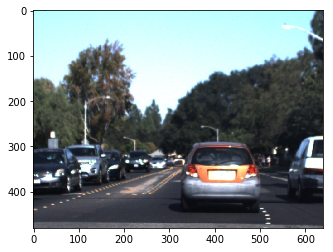

[ 0.05410521]
[ 0.05879833]


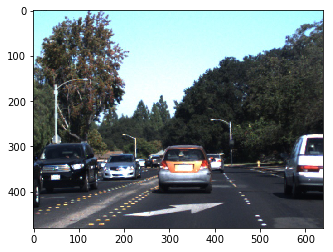

[-0.01047198]
[-0.00921353]


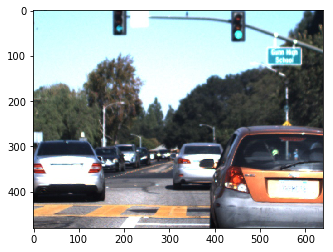

[ 0.06196602]
[ 0.06973899]


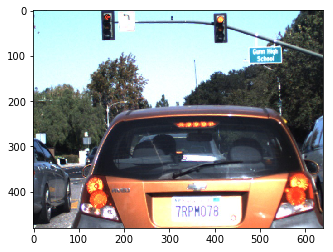

[ 0.01745329]
[ 0.01936923]


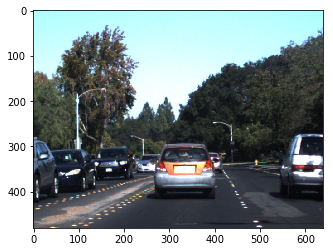

[ 0.04529742]
[ 0.04545123]


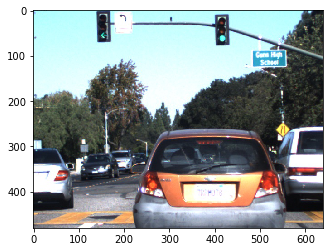

[ 0.05753567]
[ 0.06565168]


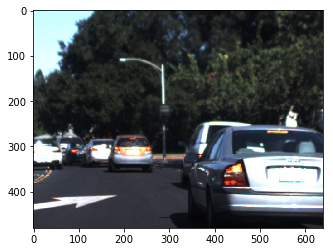

[ 0.035584]
[ 0.02613357]


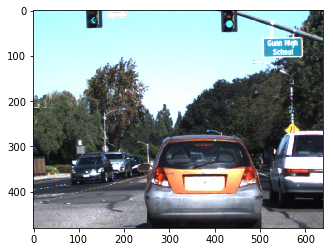

[-0.00349066]
[-0.00239482]


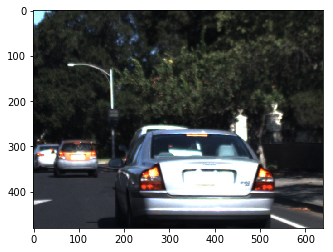

[ 0.04794548]
[ 0.04645003]


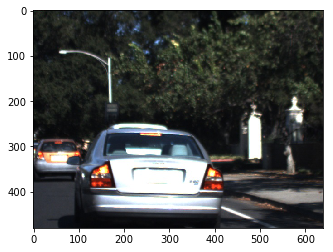

[ 0.0715585]
[ 0.0722461]


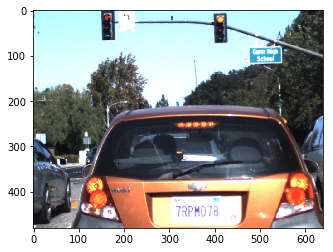

[ 0.01745329]
[ 0.01937361]


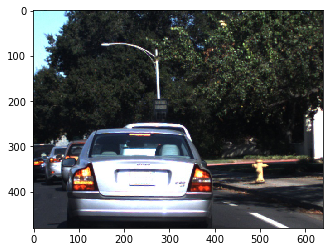

[ 0.13113919]
[ 0.12615436]


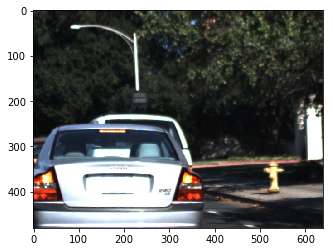

[ 0.25307274]
[ 0.24019228]


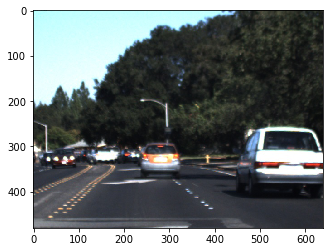

[-0.02617994]
[-0.02925854]


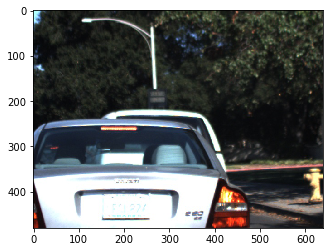

[ 0.19896753]
[ 0.19690242]


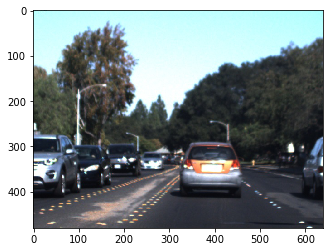

[ 0.04363323]
[ 0.04427313]


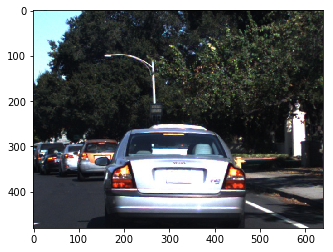

[ 0.06283186]
[ 0.0626128]


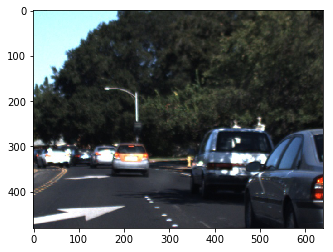

[-0.10471976]
[-0.10115482]


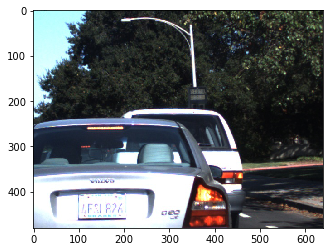

[ 0.19896753]
[ 0.1964992]


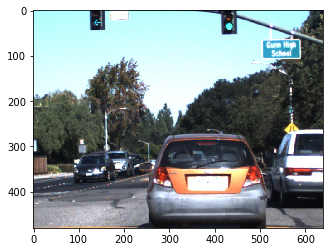

[-0.00523599]
[-0.00465976]


In [17]:
model.save("trained_v7.h5")
# testing the results
#model = load_model('trained-v4.h5')
predictions = model.predict(batch_img)

for i in range(20):
    im = np.array(batch_img[i], dtype=np.uint8)
    plt.imshow(im)
    plt.show();
    print(steering_angle[i])
    print(predictions[i])